In [6]:
import numpy as np
import numba
import math
from functools import partial
from lib import CudaProblem, Coord
import warnings
warnings.filterwarnings('ignore', category=numba.NumbaPerformanceWarning)


# Bonus: Forward pass of FlashAttention2

In the following you'll implement a simplified version of the forward pass of FlashAttention 2, as described in
Algorithm 1 in [FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning
](https://arxiv.org/abs/2307.08691).

 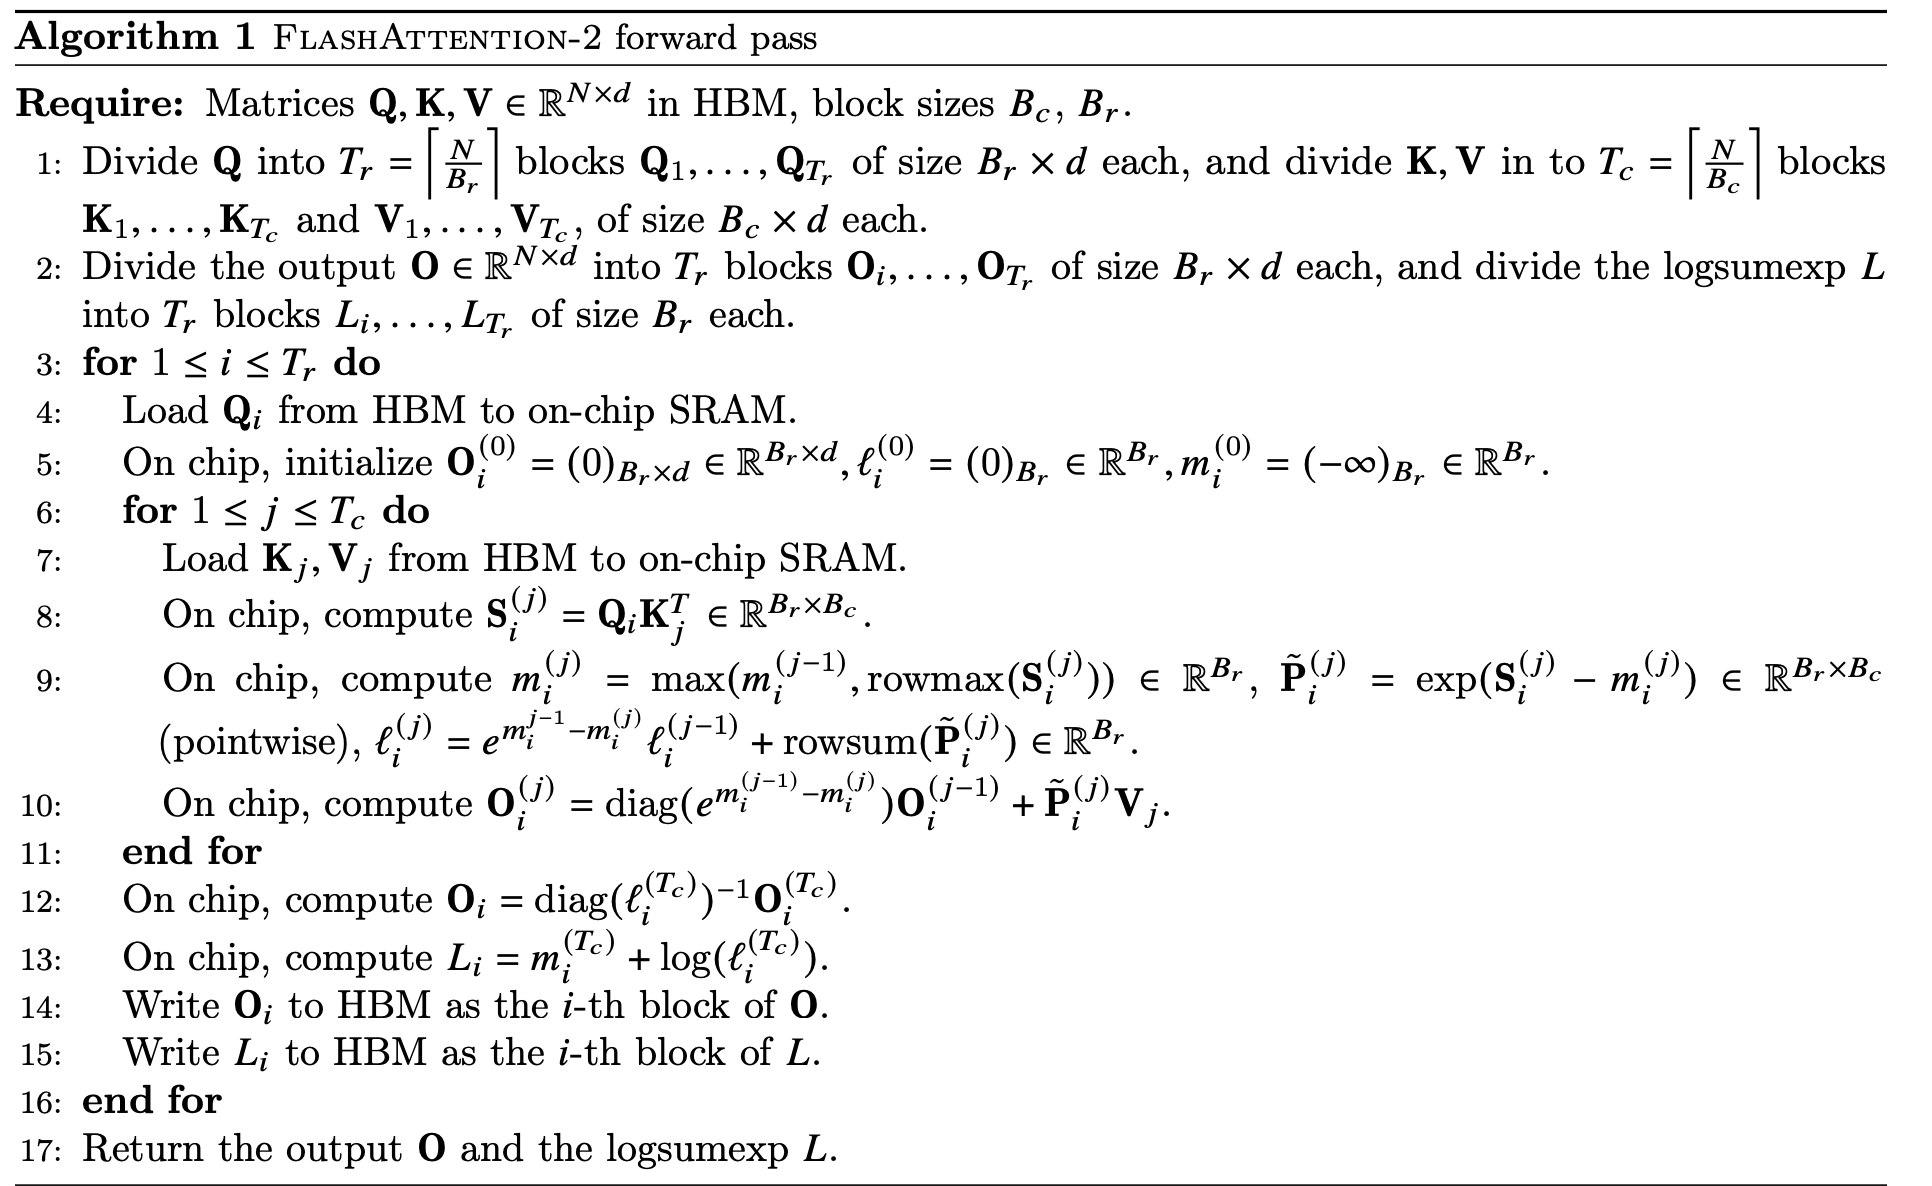

For this naive implementation, we can ignore several details, such as:
- not using optimised matmul operations that can leverage tensor cores
- not applying any within-warp optimisations
- skip storing of the "logsumexp" for rows (which is needed for the backward pass).



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MPKonst/GPU-Puzzles/blob/main/GPU_puzzlers.ipynb)

In [7]:

def flash_attn_forward_kernel_factory(cuda, tpb_x, hidden_dim):
    """
    Assumptions: 
    1) The kernel will be launched on a block_size (tpb_x, hidden_dim) on a grid size (?, 1)
    2) tpb_x < hidden_dim, so we have enough threads to compute the product (tpb_x, hidden_dim) x (hidden_dim, tpb_x) matrix
    3) tpb_x determines the parallelisation over seqlen, so we can reduce it as much as we want, to the detriment of speed.
    """
    def flash_attn_forward_kernel(out, q, k, v):
        # this will be launched as a tpb_x x hidden_dim block with hidden_dim > tpb_x
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        i = cuda.blockIdx.x * cuda.blockDim.x + local_i
        j = cuda.blockIdx.y * cuda.blockDim.y + local_j
        seqlen = q.shape[0]

        # we assume that hidden_dim is small enough that this can be loaded
        # into shared memory (we can reduce tpb_x, if not)
        q_shared = cuda.shared.array((tpb_x, hidden_dim), numba.float32)
        qkT_and_exp_qkT = cuda.shared.array((tpb_x, tpb_x), numba.float32)
        k_shared = cuda.shared.array((tpb_x, hidden_dim), numba.float32)
        v_shared = cuda.shared.array((tpb_x, hidden_dim), numba.float32)

        out_ij = 0.0
        rowsumexp_for_this_row = 0.0
        rowmax_for_my_row_up_to_now = 0.0

        if i < seqlen and j < hidden_dim:
            q_shared[local_i, local_j] = q[i, j]

        num_tiles = (seqlen + tpb_x - 1) // tpb_x
        for tile in range(num_tiles):
            n_keys = tpb_x if tile != num_tiles - 1 else seqlen - (num_tiles - 1) * tpb_x
            # FILL ME IN
            # 1. read-in the tiles of keys and values (roughly 5 lines)
            row_to_read = local_i + tile * tpb_x
            if row_to_read < seqlen and j < hidden_dim:
                k_shared[local_i, local_j] = k[row_to_read, j]
                v_shared[local_i, local_j] = v[row_to_read, j]
            cuda.syncthreads()

            # 2. compute this tile of q@k.T (roughly 6 lines)
            if i < seqlen and local_j < n_keys:
                s_ij = 0.0
                for inner_idx in range(hidden_dim):
                    s_ij += q_shared[local_i, inner_idx] * k_shared[local_j, inner_idx]
                qkT_and_exp_qkT[local_i, local_j] = s_ij
            cuda.syncthreads()

            new_rowmax = qkT_and_exp_qkT[local_i, 0]
            # 3. compute the new rowmax without updating the old one (roughly 7 lines)
            if i < seqlen:
                for key in range(1, n_keys):
                    new_rowmax = max(new_rowmax, qkT_and_exp_qkT[local_i, key])
                if tile == 0:
                    rowmax_for_my_row_up_to_now = new_rowmax
                else:
                    new_rowmax = max(rowmax_for_my_row_up_to_now, new_rowmax)
                    rescaling_factor = math.exp(rowmax_for_my_row_up_to_now - new_rowmax)

            # 4. exponentiate the attention weights 
            if i < seqlen and local_j < n_keys:
                qkT_and_exp_qkT[local_i, local_j] = math.exp(s_ij - new_rowmax)

            new_rowsumexp = 0.0
            # 5. compute the rowsumexp in the n_queries x n_keys block and 
            #    update the running rowsumexp (roughly 8 lines)
            if i < seqlen:
                for key in range(n_keys):
                    new_rowsumexp += qkT_and_exp_qkT[local_i, key]
                if tile == 0:
                    rowsumexp_for_this_row = new_rowsumexp
                else:
                    rowsumexp_for_this_row = (
                        rowsumexp_for_this_row * rescaling_factor
                        + new_rowsumexp
                    )

            # 5. compute the output contribution and update the out_ij (roughly 5 lines)
            new_out_ij = 0.0
            if i < seqlen:
                new_out_ij = 0.0
                for inner_idx in range(n_keys):
                    new_out_ij += qkT_and_exp_qkT[local_i, inner_idx] * v_shared[inner_idx, local_j]
                # collect the output
                if tile == 0:
                    out_ij = new_out_ij
                else:
                    out_ij = out_ij * rescaling_factor + new_out_ij
            
            # we can finally update the running maximum
            if i < seqlen:
                rowmax_for_my_row_up_to_now = new_rowmax
                        
        if i < seqlen:
            out[i, j] = out_ij / rowsumexp_for_this_row

    return flash_attn_forward_kernel


# Flash Attention Forward
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             7 |             1 |            85 |            12 | 



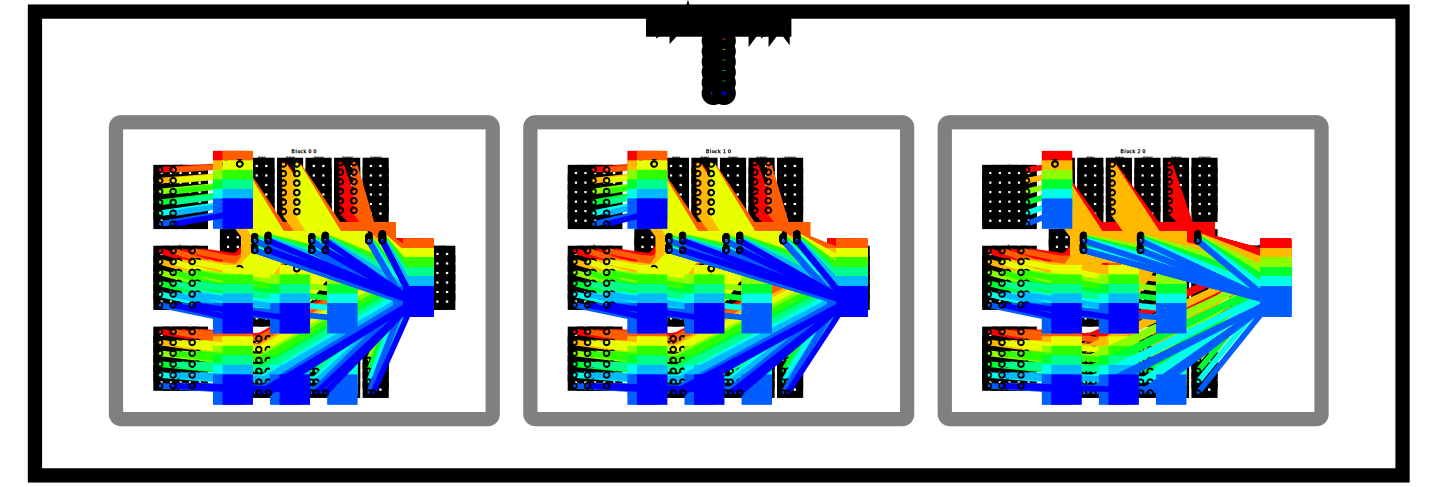

In [8]:
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

def attn_spec(q, k, v):
    return softmax(q@k.T)@v

SEQ_LEN = 5
TPB_x = 2
HIDDEN_DIM = 6
q = np.random.randn(SEQ_LEN, HIDDEN_DIM).astype(np.float32) * np.random.rand()
k = np.random.randn(SEQ_LEN, HIDDEN_DIM).astype(np.float32) * np.random.rand()
v = np.random.randn(SEQ_LEN, HIDDEN_DIM).astype(np.float32) * np.random.rand()

out = np.zeros((SEQ_LEN, HIDDEN_DIM))

problem = CudaProblem(
    "Flash Attention Forward",
    partial(flash_attn_forward_kernel_factory, tpb_x=TPB_x, hidden_dim=HIDDEN_DIM),
    [q, k, v],
    out,
    blockspergrid=Coord((SEQ_LEN + TPB_x - 1) // TPB_x, 1),
    threadsperblock=Coord(TPB_x, HIDDEN_DIM),
    spec=attn_spec,
)
problem.show(sparse=False, svg_height_factor=10)

In [9]:
problem.check()

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
: